In [ ]:
# Kevin Richard

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses
import time
import os
from IPython.display import display, Image
import cv2
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
Train_Folder ='training/'

images = []

image_files= [f for f in os.listdir(Train_Folder) if f.endswith('.jpg')]

# Load each PNG file into the images list
for image_file in image_files:
    image_path = os.path.join(Train_Folder, image_  file)
    images.append(Image(filename=image_path))


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'training/'

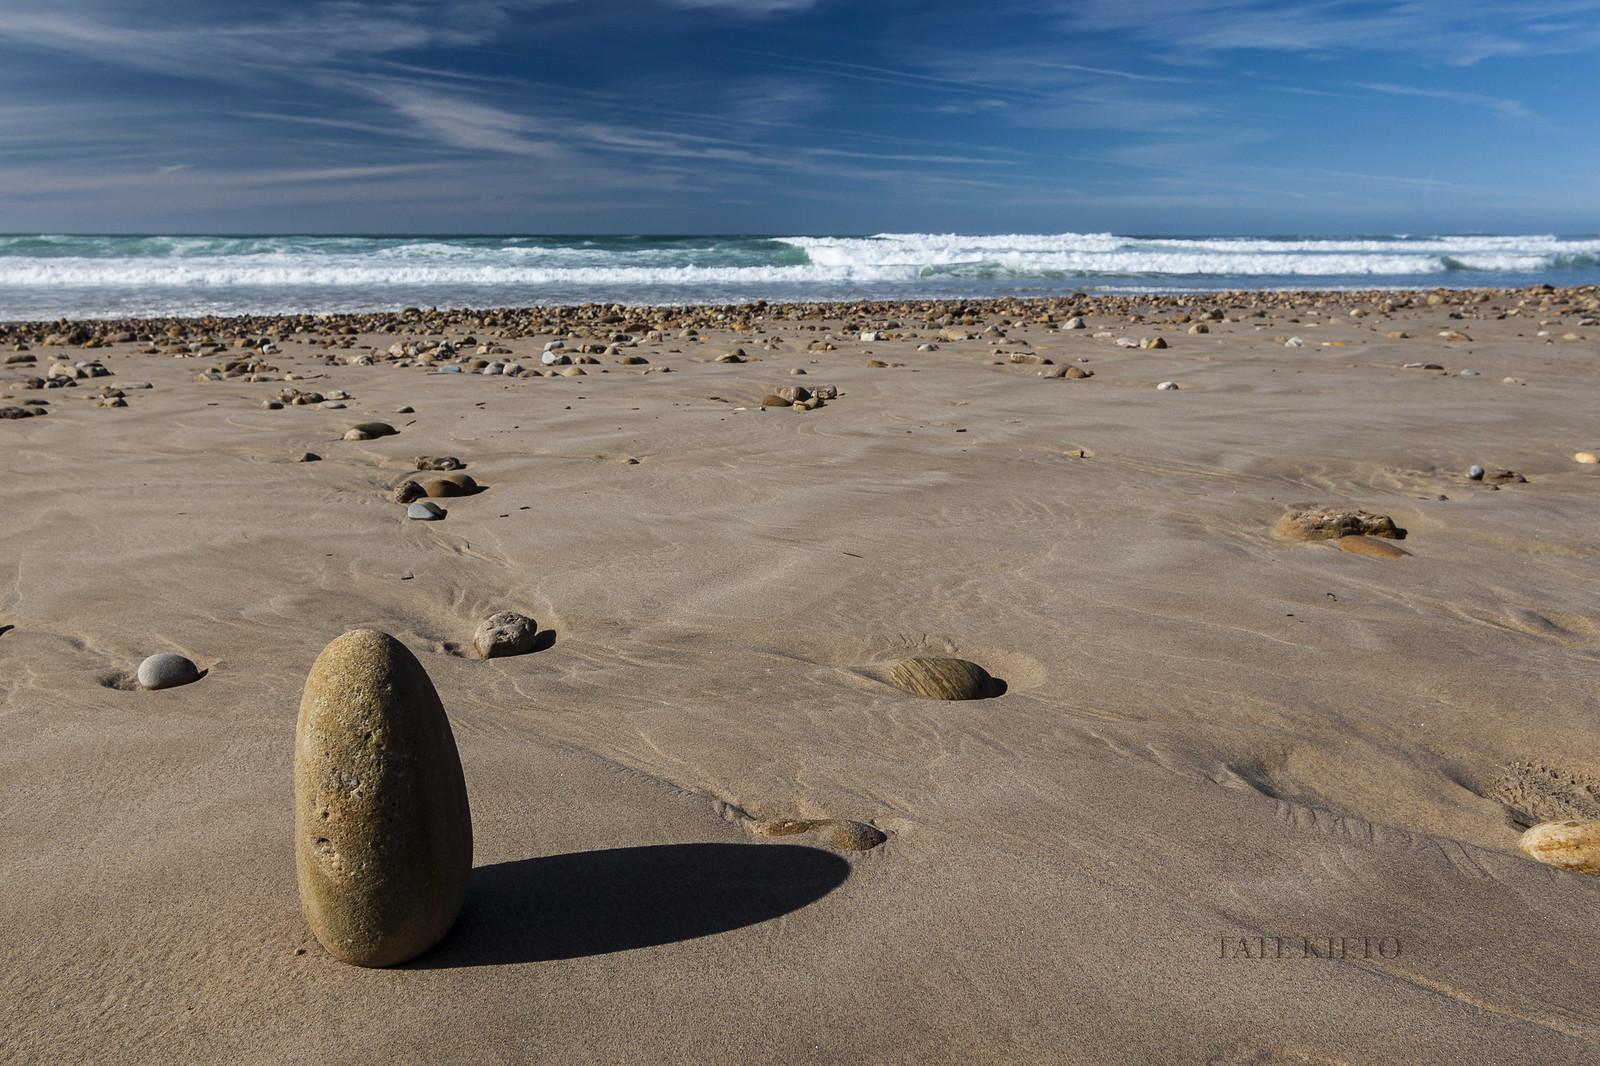

In [4]:
display(images[5])

In [33]:
sketch_list = []
image_list = []

def generate_image(image_path):
    og_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    n_image = cv2.resize(og_image, (128, 128))
    n_image[0] = n_image[0]/255.0
    n_image[1] = n_image[1]/255.0
    return n_image

def generate_outline(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    n_image = cv2.resize(image, (256, 256))
    blurred = cv2.GaussianBlur(n_image, (3, 3), 1)
    edges = cv2.Canny(blurred, 30, 60)
    inverted_edges = cv2.bitwise_not(edges)
    resized_image = cv2.resize(inverted_edges, (128, 128))
    gray_image_final = resized_image/255.0
    return gray_image_final

for image_file in image_files:
    image_path = os.path.join(Train_Folder, image_file)
    image_list.append(generate_image(image_path))
    sketch_list.append(generate_outline(image_path))

In [34]:
sketch_list[1].shape

(128, 128)

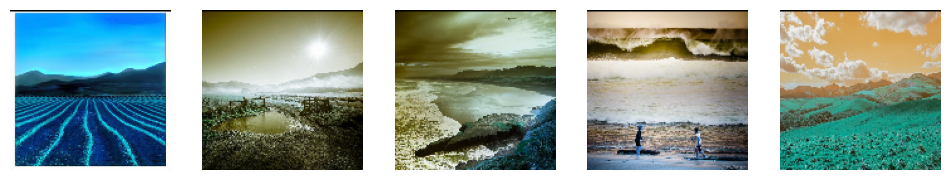

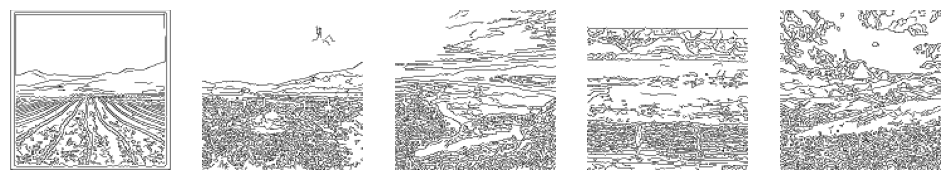

In [35]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_list[i], cmap='gray')
    plt.axis('off')
plt.show()
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sketch_list[i], cmap='gray')
    plt.axis('off')
plt.show()

In [8]:
# display(train_list[10])

In [36]:
sketch_list[5].shape

(128, 128)

In [39]:
def build_generator():
    model = models.Sequential()

    # Input layer
    model.add(layers.Input(shape=(128, 128, 1)))

    model.add(layers.Conv2DTranspose(256, (4, 4), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, (3, 3), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(32, (3, 3), strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(3, (5, 5), padding='same', activation='sigmoid'))

    return model

In [40]:
generator = build_generator()

In [41]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_3 (Conv2D  (None, 128, 128, 256)     4352      
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 128, 128, 256)     1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128, 128, 256)     0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 128, 128, 128)     524416    
 Transpose)                                                      
                                                                 
 batch_normalization_5 (Bat  (None, 128, 128, 128)     512       
 chNormalization)                                     

In [42]:
input_images = np.array(sketch_list[:4])

input_images.shape

(4, 128, 128)

In [43]:
img = generator.predict(input_images)

1/1 [==============================] - 0s 136ms/step


In [44]:
img.shape

(4, 128, 128, 3)

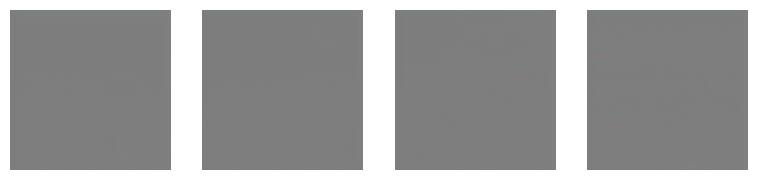

In [45]:
plt.figure(figsize=(12, 6))
for i in range(img.shape[0]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i], cmap='gray')
    plt.axis('off')
plt.show()

In [46]:
img_shape = img.shape
img_shape

(4, 128, 128, 3)

In [47]:
def build_discriminator():
    model = models.Sequential()

    model.add(layers.Input(shape=(128, 128, 3)))

    model.add(layers.Conv2D(128, (5, 5), strides=1, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (4, 4), strides=1, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (5, 5), strides=1, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [48]:
discriminator = build_discriminator()

In [49]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 128)     9728      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                                 
 dropout_3 (Dropout)         (None, 128, 128, 128)     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      131136    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)     

In [50]:
# discriminator.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
discriminator.predict(img)

1/1 [==============================] - 0s 68ms/step


array([[0.49420425],
       [0.4941286 ],
       [0.49428245],
       [0.49439362]], dtype=float32)

In [51]:
generator_optimizer = optimizers.Adam(learning_rate = 0.0001)
discriminator_optimizer = optimizers.Adam(learning_rate = 0.00001)
generator_loss = losses.BinaryCrossentropy()
discriminator_loss = losses.BinaryCrossentropy()

In [52]:
class LandscapeGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

    def train_step(self, batch):
        real_images = batch
        batch_size = tf.shape(real_images)[0]

        # Assuming Y_list is either a parameter or an attribute of the class
        Y_list_2d = tf.reshape(Y_list, (tf.shape(Y_list)[0], -1))

        # Generate random indices using TensorFlow
        random_indices = tf.random.shuffle(tf.range(tf.shape(Y_list_2d)[0]))[:batch_size]
        random_values = tf.gather(Y_list, random_indices)

        fake_images = self.generator(random_values, training=False)

        with tf.GradientTape() as discriminator_tape:
            r_images = self.discriminator(real_images, training=True)
            f_images = self.discriminator(fake_images, training=True)
            rf_images = tf.concat([r_images, f_images], axis=0)

            label_rf = tf.concat([tf.zeros_like(r_images), tf.ones_like(f_images)], axis=0)

            noise_r = 0.15 * tf.random.uniform(tf.shape(r_images))
            noise_f = -0.15 * tf.random.uniform(tf.shape(f_images))

            label_rf += tf.concat([noise_r, noise_f], axis=0)

            discriminator_loss = self.discriminator_loss(label_rf, rf_images)

        discriminator_gradient = discriminator_tape.gradient(discriminator_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(discriminator_gradient, self.discriminator.trainable_variables))

        with tf.GradientTape() as generator_tape:
            generated_images = self.generator(tf.random.normal((batch_size, 128, 128, 1)), training=True)
            predicted_labels = self.discriminator(generated_images, training=False)
            generator_loss = self.generator_loss(tf.zeros_like(predicted_labels), predicted_labels)

        generator_gradient = generator_tape.gradient(generator_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(generator_gradient, self.generator.trainable_variables))

        return {"d_loss": discriminator_loss, "g_loss": generator_loss}


In [53]:
landGAN = LandscapeGAN(generator, discriminator)

In [54]:
landGAN.compile(generator_optimizer, discriminator_optimizer, generator_loss, discriminator_loss)

In [55]:
class ModelMonitor(Callback):
    def __init__(self, num_img=1):
        self.num_img = num_img
        # self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        Y_list_2d = Y_list.reshape((Y_list.shape[0], -1))
        random_indices = np.random.choice(Y_list_2d.shape[0], self.num_img, replace=False)
        random_values = Y_list[random_indices]
        # random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_values)
        generated_images *= 255.0
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [58]:
# X_list = np.array(random.sample(train_list, k=128))
X_list = np.array(image_list)

global Y_list
Y_list = np.array(sketch_list)

# XY_list = (X_list,Y_list)

# XY_list[1].shape
Y_list[1].shape


(128, 128)

In [59]:
landscapes = landGAN.fit(X_list, epochs=500, batch_size=20, callbacks=[ModelMonitor()])


Epoch 1/500
 6/15 [===========>..................] - ETA: 1s - d_loss: 0.9878 - g_loss: 0.3715

15/15 [==============================] - 3s 222ms/step - d_loss: 0.9896 - g_loss: 0.3918
Epoch 2/500
15/15 [==============================] - 3s 224ms/step - d_loss: 1.0545 - g_loss: 0.3748
Epoch 3/500
15/15 [==============================] - 3s 225ms/step - d_loss: 1.0501 - g_loss: 0.4240
Epoch 4/500
15/15 [==============================] - 3s 223ms/step - d_loss: 1.0785 - g_loss: 0.3081
Epoch 5/500
15/15 [==============================] - 3s 222ms/step - d_loss: 1.0511 - g_loss: 0.2412
Epoch 6/500
15/15 [==============================] - 3s 223ms/step - d_loss: 1.0118 - g_loss: 0.3220
Epoch 7/500
15/15 [==============================] - 3s 227ms/step - d_loss: 0.9827 - g_loss: 0.4184
Epoch 8/500
15/15 [==============================] - 3s 225ms/step - d_loss: 0.9725 - g_loss: 0.3603
Epoch 9/500
15/15 [==============================] - 3s 223ms/step - d_loss: 0.9506 - g_loss: 0.3074
Epoch 10/500
15/15 [==============================] - 3s 223ms/step - d_loss: 0.9610 - g_loss: 0.3193
E

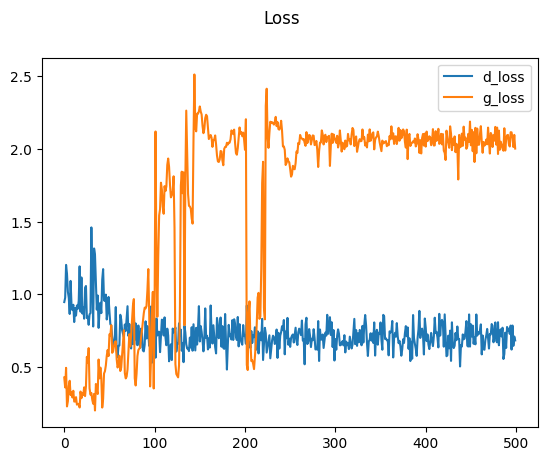

In [60]:
plt.suptitle('Loss')
plt.plot(landscapes.history['d_loss'], label='d_loss')
plt.plot(landscapes.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 18ms/step


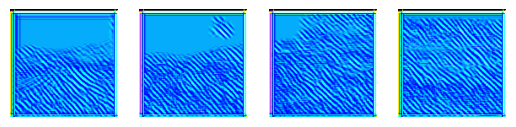

In [61]:
generated_images = generator.predict(input_images)

num_images = len(generated_images)

for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.show()



In [62]:
# import shutil

# shutil.rmtree('images')
# os.makedirs('images', exist_ok=True)

In [63]:
# generator.save('generator.h5')
# discriminator.save('discriminator.h5')

In [ ]:
# # Save the generator model in the native Keras format
# generator.save('generator_model.keras')

# # Save the discriminator model in the native Keras format
# discriminator.save('discriminator_model.keras')

In [ ]:
# from keras.models import load_model

# # Load the generator model
# loaded_generator = load_model('generator_model.h5')

# # Load the discriminator model
# loaded_discriminator = load_model('discriminator_model.h5')